In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import joblib

In [3]:
df = pd.read_excel("Данные_для_курсовои_Классическое_МО.xlsx")
df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# удалим данные для дальнейшей обработки
cols_to_drop= ['IC50, mM', 'SI', 'Unnamed: 0']
df = df.drop(cols_to_drop, axis=1)

Топ-10 наиболее важных дескрипторов для CC50 (по анализу EDA): 

LabuteASA 0.057715

BCUT2D_MWLOW 0.042473

Chi1 0.038697

Kappa3 0.038478

Kappa2 0.037475

FpDensityMorgan1 0.034774

BCUT2D_MRLOW 0.030914

MolMR 0.026832

VSA_EState7 0.023108

### Инжиниринг признаков

In [5]:
# Целевая переменная
target = 'CC50, mM'

# Исключаем ненужные столбцы
cols_to_exclude = ['IC50, mM', 'CC50, mM', 'SI']
X = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
y = df[target]

df_engineered = X.copy()

# Добавление новых признаков
if 'MolLogP' in df_engineered.columns and 'MolWt' in df_engineered.columns:
    df_engineered['MolLogP_x_MolWt'] = df_engineered['MolLogP'] * df_engineered['MolWt']

# Полиномиальные признаки
polynomial_features_cols = ['MolLogP', 'MolWt']
existing_poly_cols = [col for col in polynomial_features_cols if col in df_engineered.columns]

if existing_poly_cols:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df_engineered[existing_poly_cols])
    poly_feature_names = poly.get_feature_names_out(existing_poly_cols)

    new_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_engineered.index)
    for col in new_poly_df.columns:
        if col not in df_engineered.columns:
            df_engineered[col] = new_poly_df[col]

if 'MolLogP' in df_engineered.columns:
    df_engineered['MolLogP_gt_3'] = (df_engineered['MolLogP'] > 3).astype(int)

if df_engineered.isnull().values.any():
    imputer = SimpleImputer(strategy='median')
    df_engineered = pd.DataFrame(imputer.fit_transform(df_engineered), columns=df_engineered.columns)


### Определение моделей и функции оценки

In [7]:
# Словарь моделей
regression_models = {
    'KNN': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
    'Stacking': StackingRegressor(
        estimators=[
            ('rf', RandomForestRegressor(random_state=42)),
            ('gb', GradientBoostingRegressor(random_state=42)),
            ('xgb', XGBRegressor(random_state=42))
        ],
        final_estimator=LinearRegression()
    )
}

def evaluate_model(name, model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {'Model': name, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, model

# Оценка всех моделей
evaluation_results = []
best_model = None
best_r2 = -np.inf
best_model_name = ''

for name, model in tqdm(regression_models.items(), desc="Оценка моделей"):
    metrics, trained_model = evaluate_model(name, model, df_engineered, y)
    evaluation_results.append(metrics)

    if metrics['R2'] > best_r2:
        best_r2 = metrics['R2']
        best_model = trained_model
        best_model_name = name

# Вывод результатов
results_df = pd.DataFrame(evaluation_results).sort_values(by="R2", ascending=False)
print("Результаты моделей:")
print(results_df)

print(f"\nЛучшая модель: {best_model_name} (R2 = {best_r2:.4f})")

Оценка моделей: 100%|████████████████████████████████████████████████████████████████████| 8/8 [01:06<00:00,  8.30s/it]

Результаты моделей:
                  Model            MSE        RMSE        R2
6              CatBoost  203547.986243  451.162926  0.607391
1         Random Forest  210994.897690  459.341809  0.593028
2     Gradient Boosting  212692.749405  461.186242  0.589753
3  HistGradientBoosting  213087.388758  461.613896  0.588992
7              Stacking  213313.546019  461.858794  0.588555
5               XGBoost  216411.994263  465.201026  0.582579
4              AdaBoost  280075.806154  529.221887  0.459783
0                   KNN  431422.359035  656.827496  0.167861

Лучшая модель: CatBoost (R2 = 0.6074)


### Визуализируем

C:\Users\NikLeo\AppData\Local\Temp\ipykernel_17868\3815027730.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=sorted_df, palette='viridis')


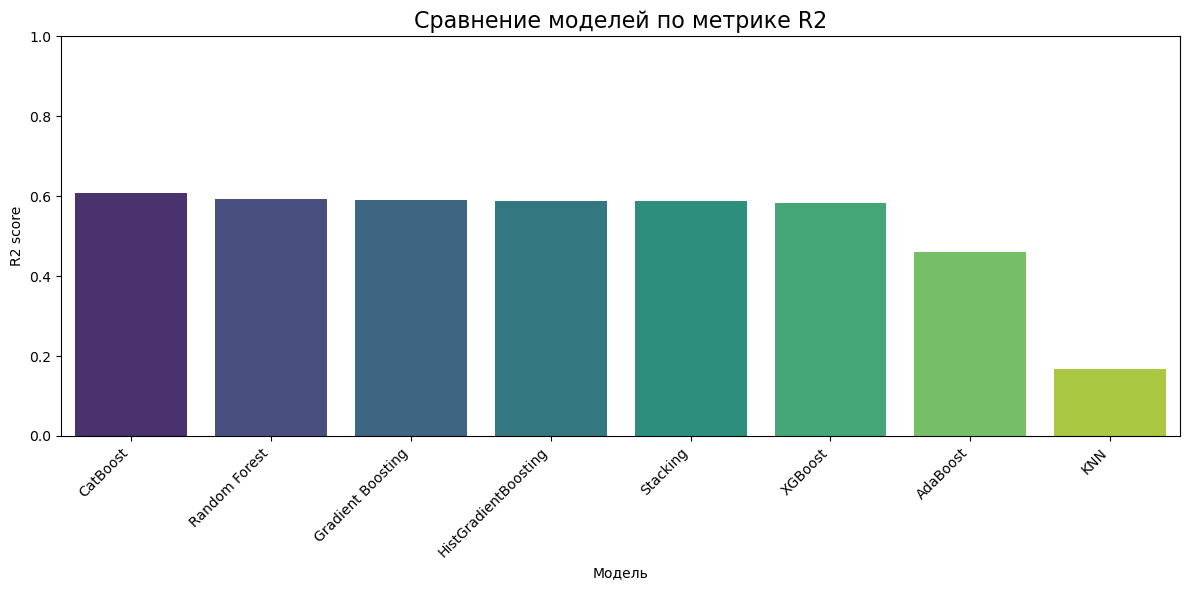


Результаты моделей (таргет: CC50, mM):


,Model,MSE,RMSE,R2
6,CatBoost,"203,547.986",451.163,0.607
1,Random Forest,"210,994.898",459.342,0.593
2,Gradient Boosting,"212,692.749",461.186,0.590
3,HistGradientBoosting,"213,087.389",461.614,0.589
7,Stacking,"213,313.546",461.859,0.589
5,XGBoost,"216,411.994",465.201,0.583
4,AdaBoost,"280,075.806",529.222,0.460
0,KNN,"431,422.359",656.827,0.168


In [8]:
from IPython.display import display

# Сортировка и округление результатов
results_df = pd.DataFrame(evaluation_results).sort_values(by='R2', ascending=False).round(3)

# Функция отображения графика сравнения моделей
def plot_model_comparison(df, metric='R2'):
    sorted_df = df.sort_values(by=metric, ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y=metric, data=sorted_df, palette='viridis')
    plt.title(f'Сравнение моделей по метрике {metric}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    if metric == 'R2':
        plt.ylim(0, 1)
    plt.ylabel(f'{metric} score')
    plt.xlabel('Модель')
    plt.tight_layout()
    plt.show()

plot_model_comparison(results_df)

# Функция красивого отображения таблицы
def display_beautiful_table(df):
    styles = [
        {'selector': 'th', 'props': [
            ('background-color', '#40466e'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f5f5f5')]},
        {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', 'white')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]}
    ]

    return (df.style
              .set_table_styles(styles)
              .format({'MSE': '{:,.3f}', 'RMSE': '{:,.3f}', 'R2': '{:,.3f}'})
              .highlight_max(subset=['R2'], color='#90EE90')
              .highlight_min(subset=['R2'], color='#FFCCCB'))

print("\nРезультаты моделей (таргет: CC50, mM):")
display(display_beautiful_table(results_df))

In [10]:
# Сохранение лучшей модели
if best_model is not None and not results_df.empty:
    best_model_name = results_df.iloc[0]['Model']
    filename = f'best_model_for_RegCC_50_{best_model_name}.pkl'
    
    
    joblib.dump(best_model, filename)
    print(f"\nЛучшая модель '{best_model_name}' успешно сохранена в файл: {filename}")



Лучшая модель 'CatBoost' успешно сохранена в файл: best_model_for_RegCC_50_CatBoost.pkl


Модель CatBoost продемонстрировала наилучшее качество среди всех протестированных регрессионных алгоритмов, показав наименьшую ошибку (MSE = 203,548) и наибольший коэффициент детерминации R² = 0.607. Это говорит о том, что модель объясняет более 60% дисперсии целевой переменной, что является хорошим результатом для регрессии в химико-биологических задачах. CatBoost особенно хорошо работает на табличных данных с категориальными признаками, что может объяснять её эффективность.

Сравнимый уровень качества показали модели Random Forest и Gradient Boosting, с R² = 0.593 и 0.590 соответственно. Несмотря на незначительно более высокие значения MSE и RMSE по сравнению с CatBoost, обе модели демонстрируют стабильные и надёжные предсказания. Их использование оправдано, особенно если требуется интерпретируемость или параллельная обработка деревьев (в случае Random Forest).

Модели HistGradientBoosting, Stacking и XGBoost продемонстрировали схожие показатели (R² ≈ 0.583–0.589), немного уступая лидерам. Это свидетельствует о том, что они также хорошо справляются с задачей, но, возможно, требуют дополнительной настройки гиперпараметров или инженерии признаков для выхода на уровень CatBoost. Особенно это касается Stacking, который несмотря на объединение сильных моделей, не дал ощутимого прироста.

Модель AdaBoost показала заметно более слабые результаты, с R² = 0.460 и RMSE > 500. Вероятно, её простая структура и меньшая устойчивость к выбросам сделали её менее подходящей для данной задачи.

Наихудшее качество продемонстрировал алгоритм K ближайших соседей (KNN) — R² составил всего 0.168, а RMSE превысил 650. Это говорит о крайне низкой способности данной модели улавливать зависимости в данных, что неудивительно — KNN плохо масштабируется и страдает от "проклятия размерности", особенно в задачах с большим числом признаков.

